In [1]:
import pandas as pd

# File paths
input_file = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/CPT6.cnr"  # Replace with your .cnr file path
output_file = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/CPT6_gene.csv"       # Specify the output .csv file path

# Read the .cnr file
df = pd.read_csv(input_file, sep="\t")  # Assuming the .cnr file is tab-delimited

# Save to CSV
df.to_csv(output_file, index=False)

print(f"File successfully converted and saved to {output_file}")

File successfully converted and saved to /bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/CPT6_gene.csv


In [2]:
import pandas as pd

# Filter out all the "Antitarget" or genes with no name, all the genes with weight less than 0.5
# Calculate the length for each bion of gene, and keep it as "length"
# Only keep four necessary columns
filtered_df = df[(df['gene'] != 'Antitarget') & (df['gene'] != '-')]
filtered_df.loc[:, 'length'] = filtered_df['end'] - filtered_df['start']
filtered_df = filtered_df[['chromosome', 'length', 'gene', 'log2']]

# Retain the original order of genes by creating an auxiliary column
filtered_df['gene_order'] = filtered_df['gene'].factorize()[0]
filtered_df.to_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/gene.csv")

# Group by 'chromosome', 'gene', and 'gene_order' to calculate the mean log2 ratio and total length
mean_log2 = (
    filtered_df.groupby(['chromosome', 'gene', 'gene_order'])
    .apply(lambda x: pd.Series({
        'log2ratio': (x['length'] * x['log2']).sum() / x['length'].sum(),  # Weighted mean for log2
        'length': x['length'].sum()  # Total length for the gene
    }))
    .reset_index()
)

# Drop the auxiliary column and sort by the original order
mean_log2 = mean_log2.sort_values('gene_order').drop(columns=['gene_order'])

# Transform all the genes to uppercase
mean_log2['gene'] = mean_log2['gene'].str.upper()

# Save the resulting DataFrame to a CSV file
mean_log2.to_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/gene_log2ratio.csv", index=False)

print(mean_log2.head())


/scratch/slurm-5056203/ipykernel_33410/4206452275.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df.loc[:, 'length'] = filtered_df['end'] - filtered_df['start']


     chromosome    gene  log2ratio  length
1217       chr1    XKR4  -0.448737  1958.0
955        chr1     RP1  -0.341689  8872.0
1047       chr1   SOX17  -0.201115  1372.0
689        chr1  MRPL15  -0.223919  1034.0
639        chr1  LYPLA1  -0.161787   900.0


In [3]:
# Find the row with the greatest length
max_length_row = mean_log2.loc[mean_log2['log2ratio'].idxmax()]

print("Row with the greatest length:")
print(max_length_row)


Row with the greatest length:
chromosome       chrY
gene            ERDR1
log2ratio     4.27816
length            4.0
Name: 22273, dtype: object


                            OLS Regression Results                            
Dep. Variable:              log2ratio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1011
Date:                Mon, 10 Feb 2025   Prob (F-statistic):              0.751
Time:                        15:26:41   Log-Likelihood:                -12234.
No. Observations:               22274   AIC:                         2.447e+04
Df Residuals:                   22272   BIC:                         2.449e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1102      0.004    -27.574      0.0

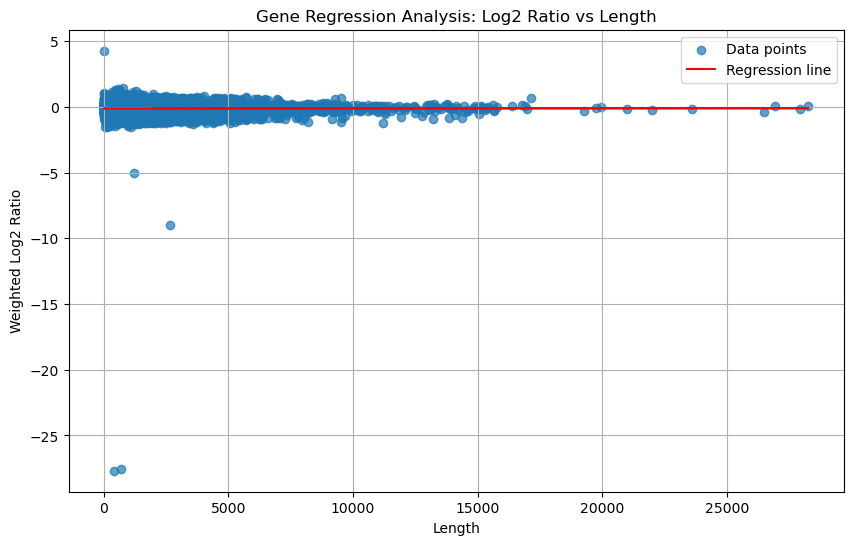

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

#Filter out TTN gene
mean_log2=mean_log2[mean_log2['gene'] != 'TTN']

# Assuming gene_stats contains the log2ratio and length data
# Perform linear regression
X = mean_log2['length']
y = mean_log2['log2ratio']

# Add a constant for the intercept
X_const = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X_const).fit()

# Print the regression summary
print(model.summary())

# Generate predictions for the regression line
mean_log2['predicted_log2ratio'] = model.predict(X_const)

# Plot the data points and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(mean_log2['length'], mean_log2['log2ratio'], alpha=0.7, label='Data points')
plt.plot(
    mean_log2['length'], 
    mean_log2['predicted_log2ratio'], 
    color='red', 
    label='Regression line'
)
plt.xlabel('Length')
plt.ylabel('Weighted Log2 Ratio')
plt.title('Gene Regression Analysis: Log2 Ratio vs Length')
plt.legend()
plt.grid(True)
plt.show()


                            OLS Regression Results                            
Dep. Variable:                   log2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     38.43
Date:                Mon, 10 Feb 2025   Prob (F-statistic):           5.68e-10
Time:                        15:26:41   Log-Likelihood:            -1.2246e+05
No. Observations:              238935   AIC:                         2.449e+05
Df Residuals:                  238933   BIC:                         2.449e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0956      0.002    -54.181      0.0

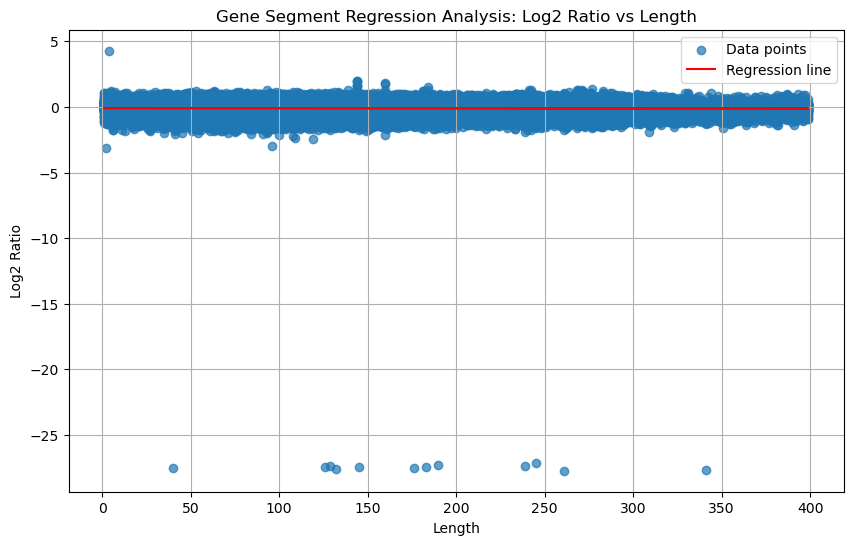

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

#Filter out TTN gene
filtered_df=filtered_df[filtered_df['gene'] != 'TTN']

# Assuming gene_stats contains the log2ratio and length data
# Perform linear regression
X = filtered_df['length']
y = filtered_df['log2']

# Add a constant for the intercept
X_const = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X_const).fit()

# Print the regression summary
print(model.summary())

# Generate predictions for the regression line
filtered_df['predicted_log2ratio'] = model.predict(X_const)

# Plot the data points and the regression line
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['length'], filtered_df['log2'], alpha=0.7, label='Data points')
plt.plot(
    filtered_df['length'], 
    filtered_df['predicted_log2ratio'], 
    color='red', 
    label='Regression line'
)
plt.xlabel('Length')
plt.ylabel('Log2 Ratio')
plt.title('Gene Segment Regression Analysis: Log2 Ratio vs Length')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
import pandas as pd
import os

file_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/gene_log2ratio.csv'


dataframe_dict = {}

original_shapes = {}


file_name = os.path.basename(file_path)
cnvkit_df = pd.read_csv(file_path)
dataframe_dict[file_name] = cnvkit_df
original_shapes[file_name] = cnvkit_df.shape


original_shapes

{'gene_log2ratio.csv': (22275, 4)}

In [5]:
def filter_cnvkit_output(df):
    # Ensure the columns 'gene' and 'log2ratio' exist in the DataFrame
    if 'gene' not in df.columns or 'log2ratio' not in df.columns:
        raise ValueError("DataFrame must contain 'gene' and 'log2ratio' columns.")
        
    # Filter for 'log2ratio' column higher or lower than certain thresholds
    high_amplification_filter = df['log2ratio'] > 0.3
    high_deletion_filter = df['log2ratio'] < -0.3
    
    # Combine filters with correct grouping
    filtered_df = df[high_amplification_filter | high_deletion_filter]
    
    return filtered_df


In [6]:
cnv_dict = {}
filtered_shapes = {}

for key, item in dataframe_dict.items():
    filtered_df = filter_cnvkit_output(item)
    cnv_dict[key] = filtered_df
    filtered_shapes[key] = filtered_df.shape

print(filtered_shapes)

{'gene_log2ratio.csv': (5965, 4)}


In [7]:
gene = "TFAP2B" 
column = "gene"

for key, df in cnv_dict.items():
    # Subset the dataframe to rows where the "Gene" column matches the requested gene
    subset = df.loc[df[column] == gene]
    
    # Check if there are any matching rows
    if not subset.empty:
        print(f"Matches found in {key}:")
        print(subset)
    else:
        print(f"No matches found in {key}")

Matches found in gene_log2ratio.csv:
   chromosome    gene  log2ratio  length
64       chr1  TFAP2B  -0.412166  1492.0


In [8]:
import pandas as pd
import numpy as np
import sys
import os

# Function to classify genes using the OncoKB database
def classify_genes_oncokb(gene_list, oncokb_df):
    tsg_list = oncokb_df[oncokb_df['Is Tumor Suppressor Gene'] == 'Yes']['Hugo Symbol'].tolist()
    oncogene_list = oncokb_df[oncokb_df['Is Oncogene'] == 'Yes']['Hugo Symbol'].tolist()

    tsgs = [gene for gene in gene_list if gene in tsg_list]
    oncogenes = [gene for gene in gene_list if gene in oncogene_list]
    return tsgs + oncogenes

def classify_genes_brca(gene_list, brca_df):
    brca_list = brca_df['Gene'].tolist()
    genes = [gene for gene in gene_list if gene in brca_list]
    return genes

MODE = "ONCOKB"  # Can be "BRCA" or "ONCOKB"

# Assuming `cnv_dict` is already defined with sample_ids as keys and cnvkit output dataframes as values
if 'cnv_dict' not in globals():
    raise ValueError("cnv_dict is not defined.")

# Load the OncoKB database file
file_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/cancerGeneList.tsv'
oncokb_df = pd.read_csv(file_path, sep='\t')

brca_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/brca_genelist.csv'
brca_df = pd.read_csv(brca_path)

# Step 1: Combine all dataframes into a single dataframe
combined_df = pd.concat(cnv_dict.values(), keys=cnv_dict.keys(), names=['Sample'])
combined_df = combined_df.reset_index(level='Sample')

# Ensure necessary columns exist
if 'gene' not in combined_df.columns or 'log2ratio' not in combined_df.columns:
    raise ValueError("combined_df must contain 'gene' and 'log2ratio' columns.")

# Step 2: Filter for oncogenes
all_genes = combined_df['gene'].unique()

if MODE == "ONCOKB":
    oncogenes = classify_genes_oncokb(all_genes, oncokb_df)
elif MODE == "BRCA":
    oncogenes = classify_genes_brca(all_genes, brca_df)

combined_df = combined_df[combined_df['gene'].isin(oncogenes)]

print(combined_df)
combined_df.to_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/list2.csv", index=False)

                   Sample chromosome   gene  log2ratio  length
224    gene_log2ratio.csv       chr1   PMS1  -0.336400  2754.0
289    gene_log2ratio.csv       chr1   CD28  -0.526858   657.0
290    gene_log2ratio.csv       chr1  CTLA4  -0.364801   672.0
333    gene_log2ratio.csv       chr1  ERBB4  -0.402952  4014.0
877    gene_log2ratio.csv       chr1   COP1  -0.388258  2202.0
...                   ...        ...    ...        ...     ...
21962  gene_log2ratio.csv       chrX   ATRX  -0.925558  7271.0
22034  gene_log2ratio.csv       chrX    BTK  -0.973099  1980.0
22167  gene_log2ratio.csv       chrX  SMC1A  -0.915898  3702.0
22169  gene_log2ratio.csv       chrX  KDM5C  -0.924316  4763.0
22247  gene_log2ratio.csv       chrX   PIGA  -0.820995  1600.0

[167 rows x 5 columns]


In [9]:
# Include only the genes that are corrected by igv
igv_corrected = pd.read_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/list_igv_corrected.csv")
included_genes = igv_corrected['gene']

combined_df = combined_df[combined_df['gene'].isin(included_genes)]
print(combined_df)

                   Sample chromosome    gene  log2ratio  length
4665   gene_log2ratio.csv       chr4  CDKN2A -27.525207   697.0
4666   gene_log2ratio.csv       chr4  CDKN2B -27.685131   393.0
10884  gene_log2ratio.csv       chr8    CDH1  -8.969047  2655.0
11154  gene_log2ratio.csv       chr9     PGR  -0.411485  2789.0
11352  gene_log2ratio.csv       chr9    FLI1  -0.386596  1359.0
...                   ...        ...     ...        ...     ...
21962  gene_log2ratio.csv       chrX    ATRX  -0.925558  7271.0
22034  gene_log2ratio.csv       chrX     BTK  -0.973099  1980.0
22167  gene_log2ratio.csv       chrX   SMC1A  -0.915898  3702.0
22169  gene_log2ratio.csv       chrX   KDM5C  -0.924316  4763.0
22247  gene_log2ratio.csv       chrX    PIGA  -0.820995  1600.0

[84 rows x 5 columns]


In [10]:
homo_df = combined_df[(combined_df['log2ratio'] > 1) | (combined_df['log2ratio'] < -1.18)]
print(homo_df)
homo_df.to_csv("/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/CNV_summary/homodeletion.csv", index=False)

                   Sample chromosome    gene  log2ratio  length
4665   gene_log2ratio.csv       chr4  CDKN2A -27.525207   697.0
4666   gene_log2ratio.csv       chr4  CDKN2B -27.685131   393.0
10884  gene_log2ratio.csv       chr8    CDH1  -8.969047  2655.0
21089  gene_log2ratio.csv      chr19    PTEN  -5.000425  1212.0


In [18]:
# List of genes to exclude
exclude_genes = homo_df['gene']

# Exclude the specified genes from combined_df
hetero_df = combined_df[~combined_df['gene'].isin(exclude_genes)]

# Display the filtered DataFrame
print(hetero_df)


                   Sample chromosome   gene  log2ratio  length
11154  gene_log2ratio.csv       chr9    PGR  -0.411485  2789.0
11352  gene_log2ratio.csv       chr9   FLI1  -0.386596  1359.0
11353  gene_log2ratio.csv       chr9   ETS1  -0.449510  1537.0
11654  gene_log2ratio.csv       chr9    ATM  -0.324780  9280.0
12255  gene_log2ratio.csv       chr9   MLH1  -0.346632  2404.0
...                   ...        ...    ...        ...     ...
21962  gene_log2ratio.csv       chrX   ATRX  -0.925558  7271.0
22034  gene_log2ratio.csv       chrX    BTK  -0.973099  1980.0
22167  gene_log2ratio.csv       chrX  SMC1A  -0.915898  3702.0
22169  gene_log2ratio.csv       chrX  KDM5C  -0.924316  4763.0
22247  gene_log2ratio.csv       chrX   PIGA  -0.820995  1600.0

[80 rows x 5 columns]


In [17]:
# Filter for chr14 and chrX
chr14_max_gene = hetero_df[hetero_df['chromosome'] == 'chr14'].nlargest(1, 'log2ratio')
chrX_max_gene = hetero_df[hetero_df['chromosome'] == 'chrX'].nlargest(1, 'log2ratio')
chr19_min_gene = hetero_df[hetero_df['chromosome'] == 'chr19'].nsmallest(1, 'log2ratio')

# Display the results
print("Gene with highest log2ratio in chr14:")
print(chr14_max_gene[['gene', 'log2ratio']])

print("\nGene with highest log2ratio in chrX:")
print(chrX_max_gene[['gene', 'log2ratio']])

print("\nGene with lowest log2ratio in chr19:")
print(chr19_min_gene[['gene', 'log2ratio']])



Gene with highest log2ratio in chr14:
        gene  log2ratio
17464  FGF14  -0.503759

Gene with highest log2ratio in chrX:
Empty DataFrame
Columns: [gene, log2ratio]
Index: []

Gene with lowest log2ratio in chr19:
Empty DataFrame
Columns: [gene, log2ratio]
Index: []


In [30]:
import pandas as pd
import gseapy
from gseapy import Biomart

# Filter hetero_df for rows where log2ratio > 0
gain_df = hetero_df[hetero_df['log2ratio'] > 0]

# Keep only the 'gene' column, remove duplicates, and reset index
gain_df = gain_df[['gene']].drop_duplicates().reset_index(drop=True)

# Convert first letter of mouse gene name to upper case
gain_df['gene'] = gain_df['gene'].str.capitalize()

# Rename the column to "mouse_gene_name"
gain_df.columns = ["mouse_gene_name"]

# Query Biomart for mouse-to-human gene mapping
bm = Biomart(host='useast.ensembl.org')
m2h = bm.query(dataset='mmusculus_gene_ensembl', 
               attributes=['ensembl_gene_id', 'external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])

# Convert query result to DataFrame
m2h_df = pd.DataFrame(m2h)

# Merge based on external gene name (mouse gene symbol)
gain_df = gain_df.merge(m2h_df, left_on='mouse_gene_name', right_on='external_gene_name', how='left')

# Keep only necessary columns
gain_df = gain_df[['mouse_gene_name', 'hsapiens_homolog_associated_gene_name']]

# Save only the human gene column without the header
gain_df['hsapiens_homolog_associated_gene_name'].dropna().to_csv(
    "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/enrichr/gain/gain.csv", 
    index=False, 
    header=False
)

# Display the results
print(gain_df.head())


2025-02-27 11:04:13,171 [WARNING] host useast.ensembl.org is not reachable, try useast.ensembl.org 


KeyboardInterrupt: 

In [36]:
import gseapy
from gseapy import enrichr

# Run enrichment analysis using Enrichr on your gene list
enr = gseapy.enrichr(
    gene_list='/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/enrichr/gain.csv',
    gene_sets=['KEGG_2021_Human'],     
    organism='Human',                 
    outdir='/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/enrichr/gain', 
    cutoff=0.05
)

# View the top results
print(enr.results.head())

          Gene_set                                               Term Overlap  \
0  KEGG_2021_Human                                 Pathways in cancer   7/531   
1  KEGG_2021_Human                                      Breast cancer   4/147   
2  KEGG_2021_Human                                     Gastric cancer   4/149   
3  KEGG_2021_Human                           Hepatocellular carcinoma   4/168   
4  KEGG_2021_Human  PD-L1 expression and PD-1 checkpoint pathway i...    3/89   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  2.206587e-07          0.000021            0                     0   
1  7.911585e-06          0.000259            0                     0   
2  8.346288e-06          0.000259            0                     0   
3  1.340785e-05          0.000312            0                     0   
4  6.622434e-05          0.001232            0                     0   

   Odds Ratio  Combined Score                                   Genes  
0   23.6

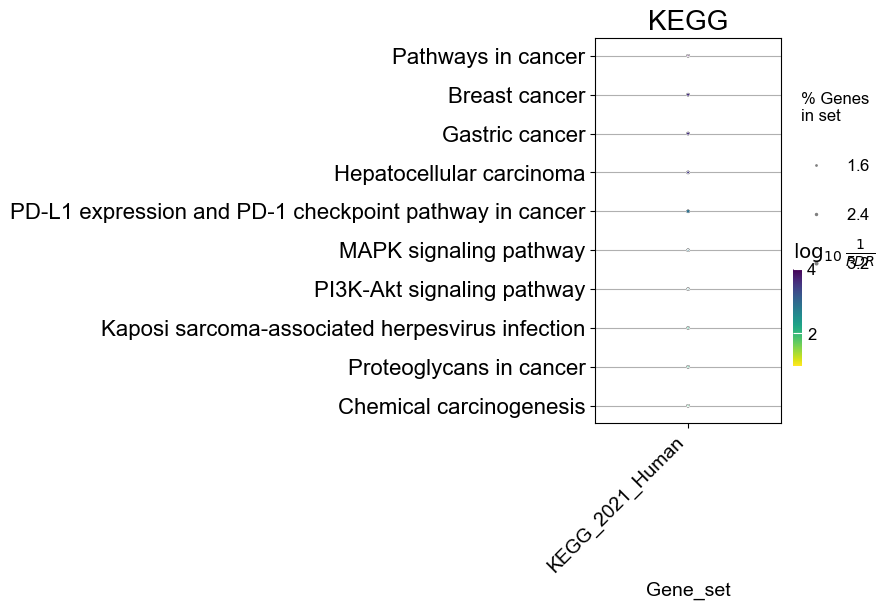

In [37]:
# simple plotting function
from gseapy import barplot, dotplot

# categorical scatterplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
              cutoff=1
             )

In [38]:
import pandas as pd
import gseapy
from gseapy import Biomart

# Filter hetero_df for rows where log2ratio < 0
loss_df = hetero_df[hetero_df['log2ratio'] < 0]

# Keep only the 'gene' column, remove duplicates, and reset index
loss_df = loss_df[['gene']].drop_duplicates().reset_index(drop=True)

# Convert first letter of mouse gene name to upper case
loss_df['gene'] = loss_df['gene'].str.capitalize()

# Rename the column to "mouse_gene_name"
loss_df.columns = ["mouse_gene_name"]

# Query Biomart for mouse-to-human gene mapping
bm = Biomart(host='useast.ensembl.org')
m2h = bm.query(dataset='mmusculus_gene_ensembl', 
               attributes=['ensembl_gene_id', 'external_gene_name',
                           'hsapiens_homolog_ensembl_gene',
                           'hsapiens_homolog_associated_gene_name'])

# Convert query result to DataFrame
m2h_df = pd.DataFrame(m2h)

# Merge based on external gene name (mouse gene symbol)
loss_df = loss_df.merge(m2h_df, left_on='mouse_gene_name', right_on='external_gene_name', how='left')

# Keep only necessary columns
loss_df = loss_df[['mouse_gene_name', 'hsapiens_homolog_associated_gene_name']]

# Save only the human gene column without the header
loss_df['hsapiens_homolog_associated_gene_name'].dropna().to_csv(
    "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/enrichr/loss/loss.csv", 
    index=False, 
    header=False
)

# Display the results
print(loss_df.head())


2025-02-27 11:11:55,719 [WARNING] host useast.ensembl.org is not reachable, try useast.ensembl.org 


  mouse_gene_name hsapiens_homolog_associated_gene_name
0             Pgr                                   PGR
1            Fli1                                  FLI1
2            Ets1                                  ETS1
3             Atm                                   ATM
4            Mlh1                                  MLH1


In [46]:
import gseapy
from gseapy import enrichr

# Run enrichment analysis using Enrichr on your gene list
enr = gseapy.enrichr(
    gene_list='/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/enrichr/loss/loss.csv',
    gene_sets=['Reactome_Pathways_2024'],     
    organism='Human',                 
    outdir='/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/enrichr/loss', 
    cutoff=0.05
)

# View the top results
print(enr.results.head())

                 Gene_set                                        Term  \
0  Reactome_Pathways_2024             Gene Expression (Transcription)   
1  Reactome_Pathways_2024  Establishment of Sister Chromatid Cohesion   
2  Reactome_Pathways_2024                                  Cell Cycle   
3  Reactome_Pathways_2024               Cellular Responses to Stimuli   
4  Reactome_Pathways_2024                                     Meiosis   

   Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  17/1615  0.000003          0.001039            0                     0   
1     3/11  0.000004          0.001039            0                     0   
2   10/649  0.000021          0.003502            0                     0   
3   11/887  0.000057          0.007149            0                     0   
4     4/89  0.000148          0.009950            0                     0   

   Odds Ratio  Combined Score  \
0    4.537853       57.294341   
1  131.131579     1624.619362   

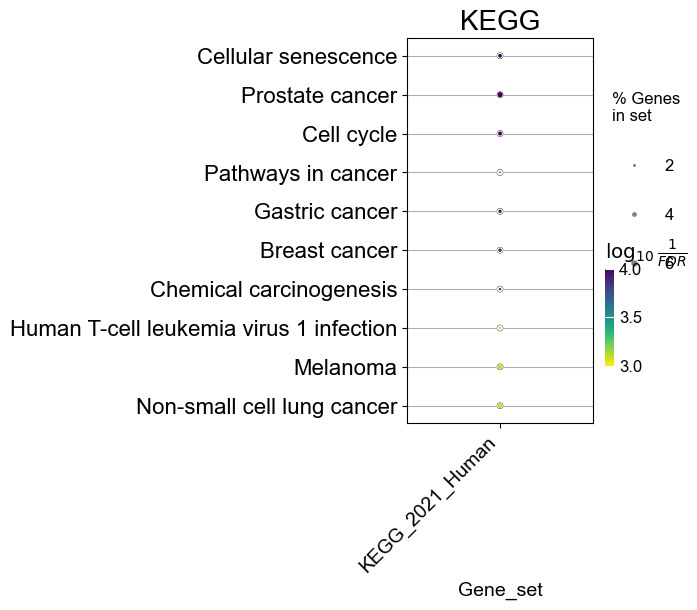

In [40]:
# simple plotting function
from gseapy import barplot, dotplot

# categorical scatterplot
ax = dotplot(enr.results,
              column="Adjusted P-value",
              x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
              size=10,
              top_term=10,
              figsize=(3,5),
              title = "KEGG",
              xticklabels_rot=45, # rotate xtick labels
              show_ring=True, # set to False to revmove outer ring
              marker='o',
              cutoff=1
             )

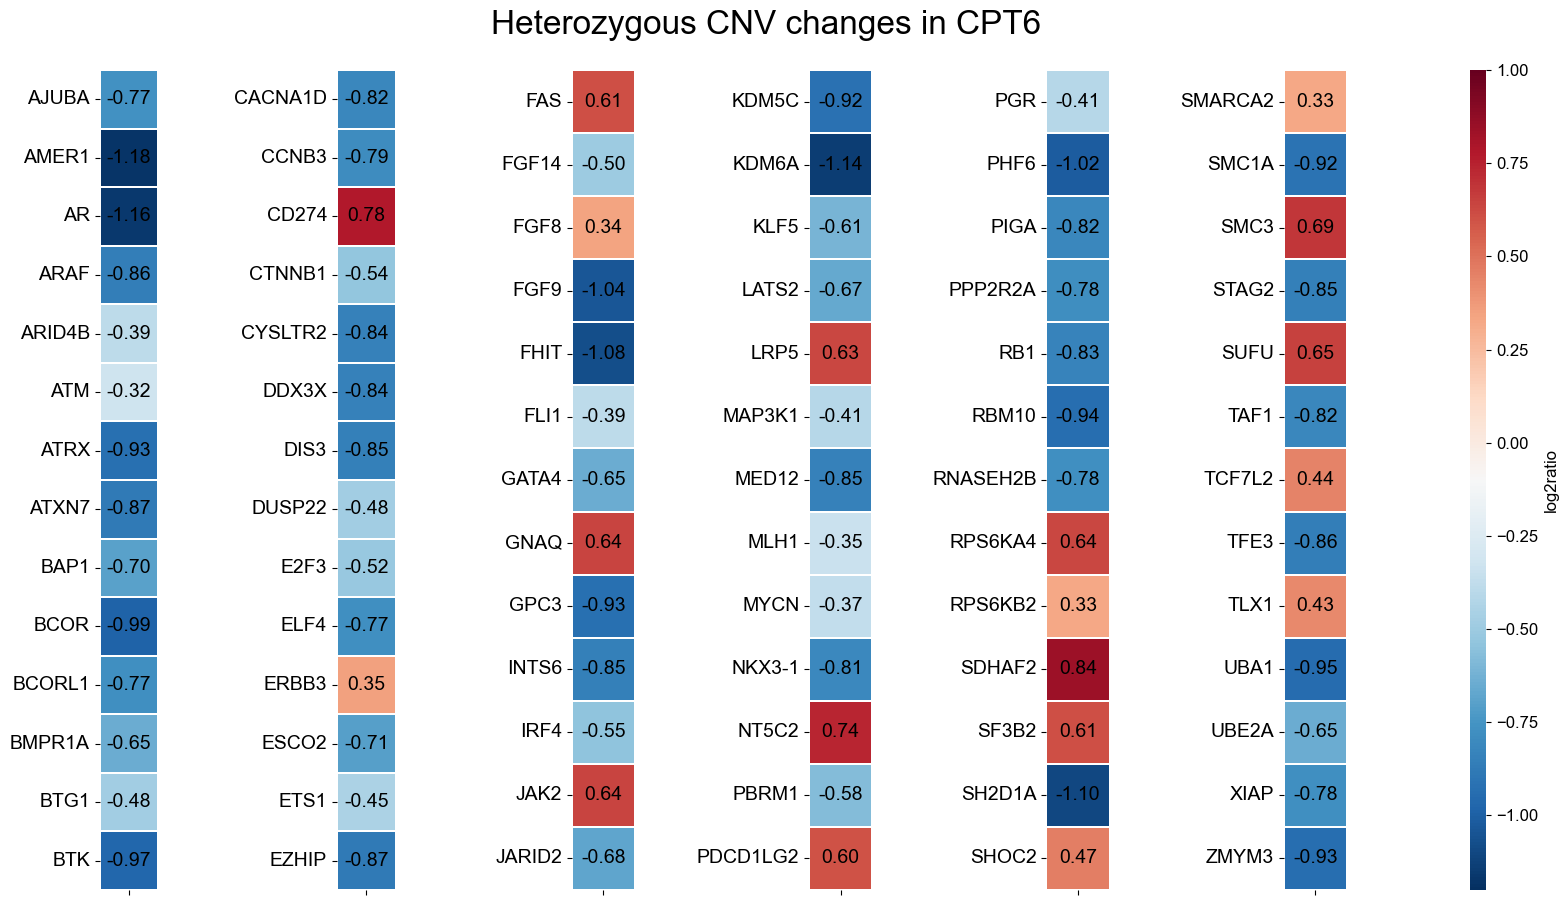

<Figure size 640x480 with 0 Axes>

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colorbar
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

# Update the font cache
# Path to the Arial font file
from matplotlib import font_manager
font_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/Arial.ttf'
font_manager.fontManager.addfont(font_path)
# Set default font to Arial and minimum font size to 12
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12


# Extract necessary columns
heatmap_data = hetero_df[['gene', 'log2ratio']]

# Set Gene Symbol as index for better heatmap visualization
heatmap_data = heatmap_data.set_index('gene')

# Step 4: Sort genes alphabetically by the index
heatmap_data = heatmap_data.sort_index()

# Split data into 6 columns (chunks)
n_cols = 6
chunks = np.array_split(heatmap_data, n_cols)

# Create subplots for 6 columns
fig, axes = plt.subplots(nrows=1, ncols=n_cols + 1, figsize=(16, 10), gridspec_kw={'width_ratios': [1] * n_cols + [0.1]})

# Plot each chunk in a separate column
for i, ax in enumerate(axes[:-1]):  # Exclude the last axis for the color bar
    if i < len(chunks):
        sns.heatmap(
            chunks[i],
            cmap='RdBu_r',
            norm = Normalize(vmin=-1.2, vmax=1),
            square=True,
            yticklabels=True,
            ax=ax,
            annot=True,  # Enable annotations
            fmt=".2f",  # Format numbers to 2 decimal places
            annot_kws={"size": 14, "color": "black"},  # Customize font size and color
            cbar=(i == len(chunks) - 1),  # Add color bar only for the last column
            cbar_kws={'shrink': 0.6, 'label': 'log2ratio'} if i == len(chunks) - 1 else None,  # Customize color bar
            cbar_ax=axes[-1],
            linewidths = 0.2
        )
        ax.set_xlabel('')
        if i == 0:
            ax.set_ylabel("", fontsize=16)  # Change the y-axis label
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='y', rotation=0, labelsize=14)
        ax.set_xticklabels(['']) 

# Adding title to the plot
fig.suptitle('Heterozygous CNV changes in CPT6', fontsize=24, fontweight='bold')

# Adjust layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.1, wspace=0.5)
plt.show()

# Save the plot as an SVG file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "low_level.pdf")
plt.savefig(output_file, format='pdf')

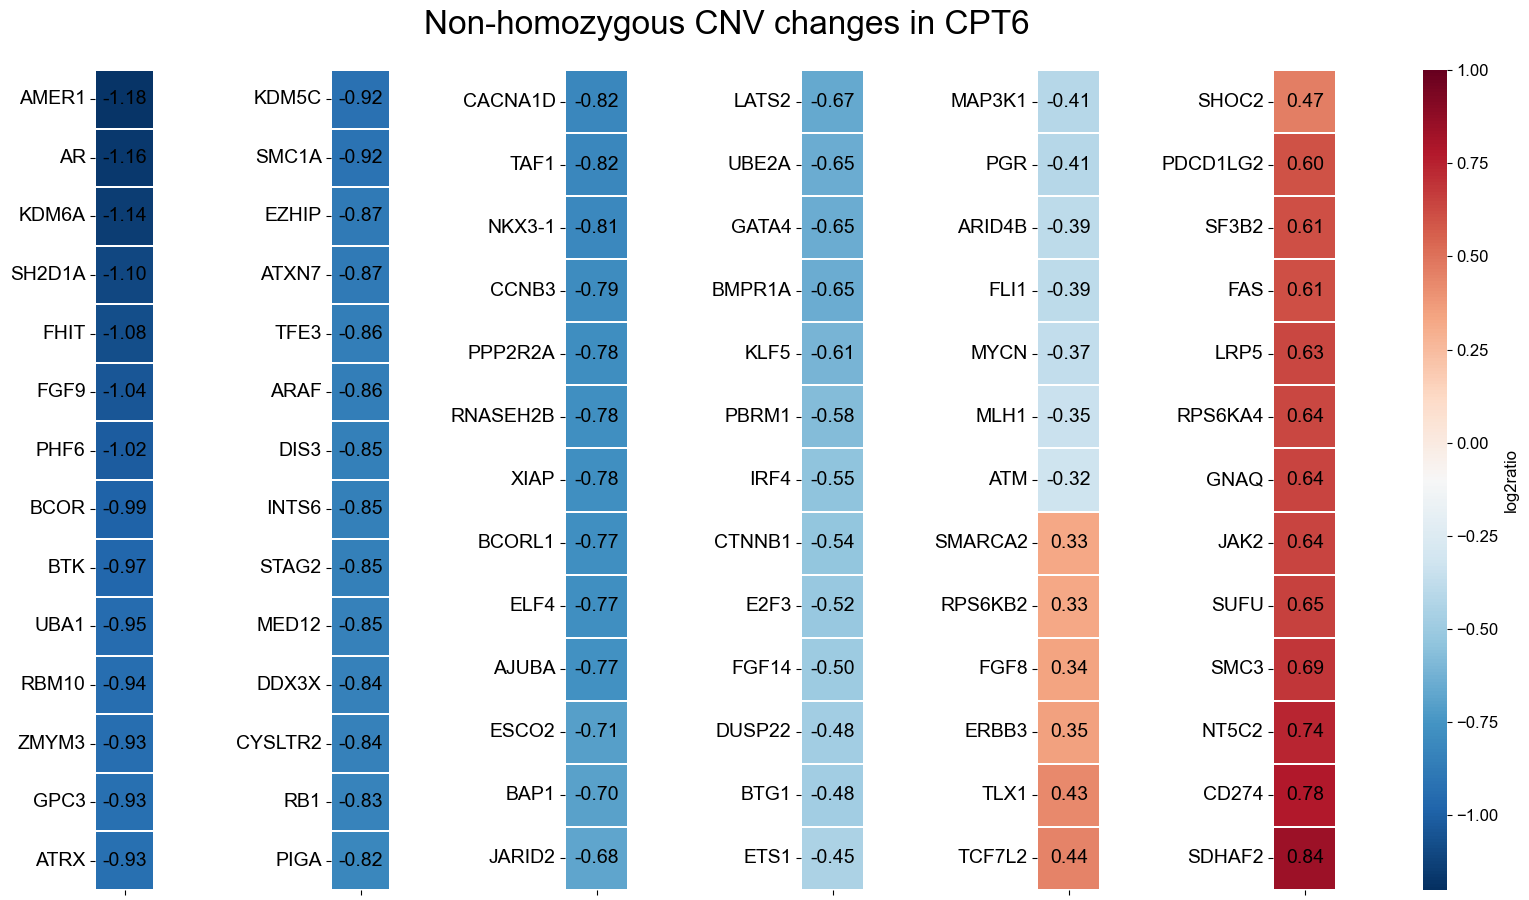

<Figure size 640x480 with 0 Axes>

In [20]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.colors import Normalize

# Path to the Arial font file
font_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/Arial.ttf'
font_manager.fontManager.addfont(font_path)
# Set default font to Arial and minimum font size to 12
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# Extract necessary columns
heatmap_data = hetero_df[['gene', 'log2ratio']]

# Set Gene Symbol as index for better heatmap visualization
heatmap_data = heatmap_data.set_index('gene')

# Sort genes by log2ratio value (smallest to largest)
heatmap_data = heatmap_data.sort_values(by='log2ratio')

# Split data into 6 columns (chunks)
n_cols = 6
chunks = np.array_split(heatmap_data, n_cols)

# Create subplots for 6 columns
fig, axes = plt.subplots(nrows=1, ncols=n_cols + 1, figsize=(16, 10), gridspec_kw={'width_ratios': [1] * n_cols + [0.1]})

# Plot each chunk in a separate column
for i, ax in enumerate(axes[:-1]):  # Exclude the last axis for the color bar
    if i < len(chunks):
        sns.heatmap(
            chunks[i],
            cmap='RdBu_r',
            norm=Normalize(vmin=-1.2, vmax=1),
            square=True,
            yticklabels=True,
            ax=ax,
            annot=True,  # Enable annotations
            fmt=".2f",  # Format numbers to 2 decimal places
            annot_kws={"size": 14, "color": "black"},  # Customize font size and color
            cbar=(i == len(chunks) - 1),  # Add color bar only for the last column
            cbar_kws={'shrink': 0.6, 'label': 'log2ratio'} if i == len(chunks) - 1 else None,  # Customize color bar
            cbar_ax=axes[-1],
            linewidths=0.2
        )
        ax.set_xlabel('')
        if i == 0:
            ax.set_ylabel("", fontsize=16)  # Change the y-axis label
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='y', rotation=0, labelsize=14)
        ax.set_xticklabels(['']) 

# Adding title to the plot
fig.suptitle('Non-homozygous CNV changes in CPT6', fontsize=24, fontweight='bold')

# Adjust layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.1, wspace=0)
plt.show()

# Save the plot as a PDF file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "low_level.pdf")
plt.savefig(output_file, format='pdf')


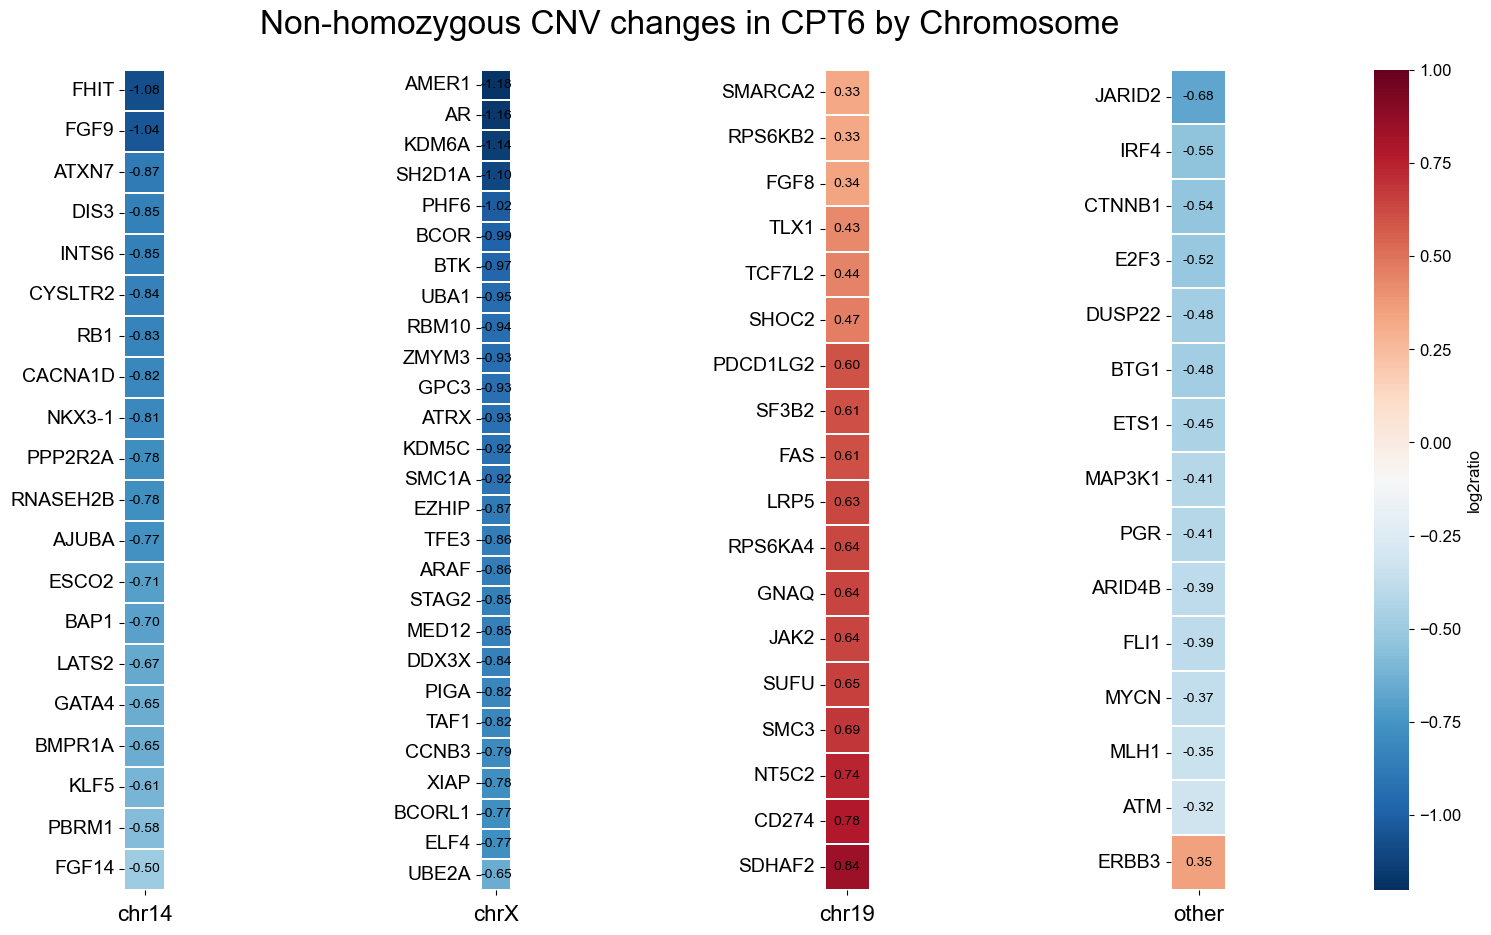

<Figure size 640x480 with 0 Axes>

In [22]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager
from matplotlib.colors import Normalize

# Path to the Arial font file
font_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/Arial.ttf'
font_manager.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 12

# Assuming hetero_df has columns: 'gene', 'log2ratio', and 'chromosome'

# Filter and sort the data by chromosome groups
data_chr14 = (
    hetero_df[hetero_df['chromosome'] == 'chr14'][['gene', 'log2ratio']]
    .set_index('gene')
    .sort_values(by='log2ratio')
)
data_chrX = (
    hetero_df[hetero_df['chromosome'] == 'chrX'][['gene', 'log2ratio']]
    .set_index('gene')
    .sort_values(by='log2ratio')
)
data_chr19 = (
    hetero_df[hetero_df['chromosome'] == 'chr19'][['gene', 'log2ratio']]
    .set_index('gene')
    .sort_values(by='log2ratio')
)
data_other = (
    hetero_df[~hetero_df['chromosome'].isin(['chr14', 'chr19', 'chrX'])][['gene', 'log2ratio']]
    .set_index('gene')
    .sort_values(by='log2ratio')
)

# List of groups in the desired order: chr14, chrX, chr19, other
group_list = [data_chr14, data_chrX, data_chr19, data_other]
chrom_labels = ['chr14', 'chrX', 'chr19', 'other']

# Create subplots: 4 heatmap columns plus one extra column for the colorbar
fig, axes = plt.subplots(nrows=1, ncols=4 + 1, figsize=(16, 10),
                         gridspec_kw={'width_ratios': [1] * 4 + [0.1]})

# Plot each group in its respective column
for i, ax in enumerate(axes[:-1]):  # Exclude the last axis (for colorbar)
    if i < len(group_list):
        sns.heatmap(
            group_list[i],
            cmap='RdBu_r',
            norm=Normalize(vmin=-1.2, vmax=1),
            square=True,
            yticklabels=True,
            ax=ax,
            annot=True,         # Enable annotations
            fmt=".2f",          # Format numbers to 2 decimal places
            annot_kws={"size": 10, "color": "black"},  # Decreased annotation font size
            cbar=(i == len(group_list) - 1),  # Add color bar only for the last heatmap
            cbar_kws={'shrink': 0.6, 'label': 'log2ratio'} if i == len(group_list) - 1 else None,
            cbar_ax=axes[-1],
            linewidths=0.2
        )
        # Set the x-axis label to annotate the chromosome name at the bottom
        ax.set_xlabel(chrom_labels[i], fontsize=16)
        if i == 0:
            ax.set_ylabel("", fontsize=16)  # Only the first subplot gets a y-axis label (if desired)
        else:
            ax.set_ylabel('')
        ax.tick_params(axis='y', rotation=0, labelsize=14)
        # Remove x-tick labels to avoid clutter (chromosome names are provided via x-label)
        ax.set_xticklabels([''])
        
# Add a title to the figure
fig.suptitle('Non-homozygous CNV changes in CPT6 by Chromosome', fontsize=24, fontweight='bold')

# Adjust layout to avoid overlap
plt.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.1, wspace=0)
plt.show()

# Save the plot as a PDF file
output_dir = "output_plots"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "low_level_by_chromosome_updated.pdf")
plt.savefig(output_file, format='pdf')


In [76]:
# Define the minimum log2ratio value in the dataset
min_log2 = homo_df['log2ratio'].min()

# Apply normalization
homo_df['normalized_log2ratio'] = -1 + (homo_df['log2ratio'] - (-1.18)) * (-1.18 / (min_log2 + 1.18))

# Display the results
print(homo_df[['gene', 'log2ratio', 'normalized_log2ratio']])


         gene  log2ratio  normalized_log2ratio
4665   CDKN2A -27.525207             -2.172880
4666   CDKN2B -27.685131             -2.180000
10884    CDH1  -8.969047             -1.346766
21089    PTEN  -5.000425             -1.170084


/scratch/slurm-4932088/ipykernel_54104/2957180913.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  homo_df['normalized_log2ratio'] = -1 + (homo_df['log2ratio'] - (-1.18)) * (-1.18 / (min_log2 + 1.18))


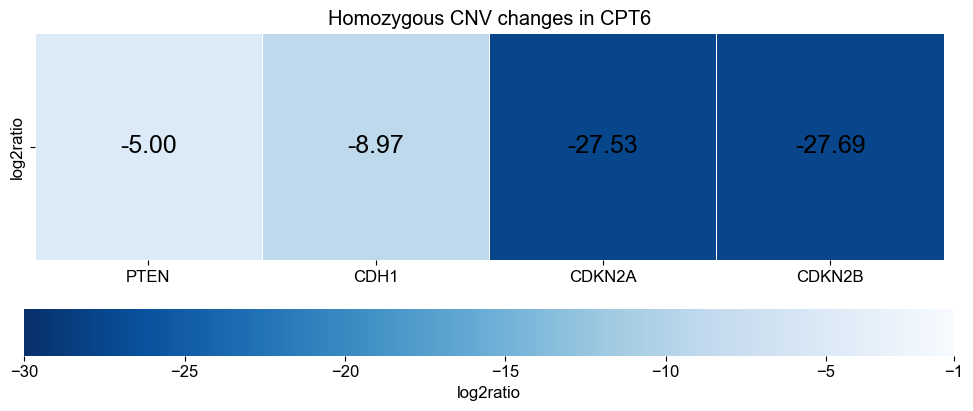

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Extract necessary columns
heatmap_data = homo_df[['gene', 'log2ratio']]

# Sort genes by log2ratio in decreasing order
heatmap_data = heatmap_data.sort_values('log2ratio', ascending=False)

# Transpose the dataframe to make genes columns for horizontal orientation
heatmap_data = heatmap_data.set_index('gene').T

# Define normalization
norm = Normalize(vmin=-30, vmax=-1)

# Plotting the heatmap
plt.figure(figsize=(10, 4))  # Adjust width for horizontal orientation
sns.heatmap(
    heatmap_data,
    cmap='Blues_r', 
    norm=norm,  # Use reversed normalization
    cbar_kws={
        'label': 'log2ratio',
        'orientation': 'horizontal',
        'ticks': [-30, -25, -20, -15, -10, -5, -1]  # Tick positions
    },
    annot=True,  # Enable annotations
    fmt=".2f",  # Format numbers to 2 decimal places
    annot_kws={"size": 18, "color": "black"},  # Customize font size and color
    square=True,
    linewidths=0.6
)

plt.title('Homozygous CNV changes in CPT6')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()


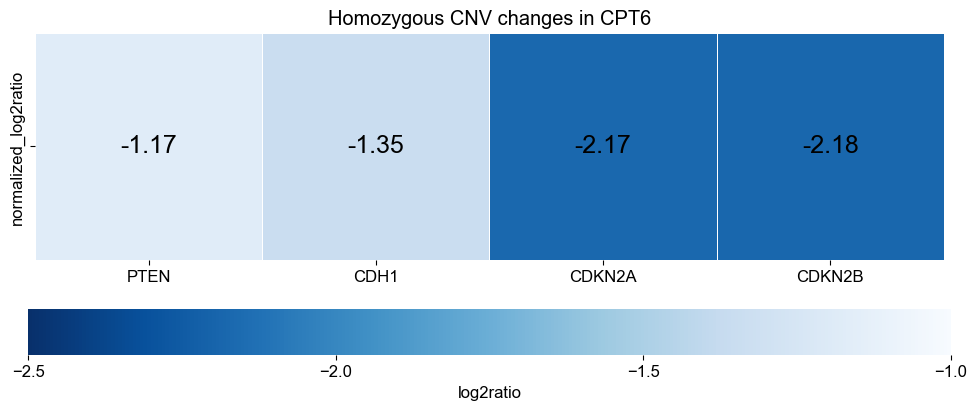

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

# Extract necessary columns
heatmap_data = homo_df[['gene', 'normalized_log2ratio']]

# Sort genes by log2ratio in decreasing order
heatmap_data = heatmap_data.sort_values('normalized_log2ratio', ascending=False)

# Transpose the dataframe to make genes columns for horizontal orientation
heatmap_data = heatmap_data.set_index('gene').T

# Define normalization
norm = Normalize(vmin=-2.5, vmax=-1)

# Plotting the heatmap
plt.figure(figsize=(10, 4))  # Adjust width for horizontal orientation
sns.heatmap(
    heatmap_data,
    cmap='Blues_r', 
    norm=norm,  # Use reversed normalization
    cbar_kws={
        'label': 'log2ratio',
        'orientation': 'horizontal',
        'ticks': [-2.5, -2, -1.5, -1]  # Tick positions
    },
    annot=True,  # Enable annotations
    fmt=".2f",  # Format numbers to 2 decimal places
    annot_kws={"size": 18, "color": "black"},  # Customize font size and color
    square=True,
    linewidths=0.6
)

plt.title('Homozygous CNV changes in CPT6')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()


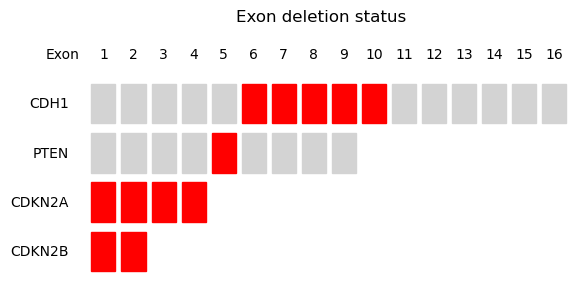

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the Excel file
file_path = '/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/Exon_status_CPT6.xlsx'
df = pd.read_excel(file_path, index_col=0)  # Assuming the first column is exon names

df = df.T  # Transpose the dataframe to swap exons and genes

# Rename columns to numerical values
exon_labels = list(range(1, len(df.columns) + 1))
df.columns = exon_labels

# Plot settings
fig, ax = plt.subplots(figsize=(len(df.columns) * 0.4, len(df) * 0.8))  # Adjust figure size
ax.set_xticks([])  # Remove x-axis numbers
ax.set_yticks(np.arange(len(df)))  # Adjust spacing between rows
ax.set_xticklabels([])  # Remove x-axis labels
ax.set_yticklabels(df.index, va='center')  # Ensure gene names align with boxes
ax.yaxis.tick_left()
ax.tick_params(axis='both', length=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Add exon label row above the heatmap
for j, label in enumerate(exon_labels):
    ax.text(j, -1, str(label), ha='center', va='center', fontsize=10)
ax.text(-0.8, -1, "Exon", ha='right', va='center', fontsize=10)

# Draw the rectangles with colors
for i, gene in enumerate(df.index):
    for j, exon in enumerate(df.columns):
        value = df.loc[gene, exon]
        if pd.isna(value):
            continue  # Skip NA values
        color = '#d3d3d3' if value == 1 else 'red'  # Lighten grey color
        ax.add_patch(plt.Rectangle((j - 0.4, i - 0.4), 0.8, 0.8, color=color, ec=color))  # Adjust height and spacing

ax.set_xlim(-1, len(df.columns) - 0.5)
ax.set_ylim(len(df) - 0.5, -1.5)
plt.title('Exon deletion status')
plt.show()

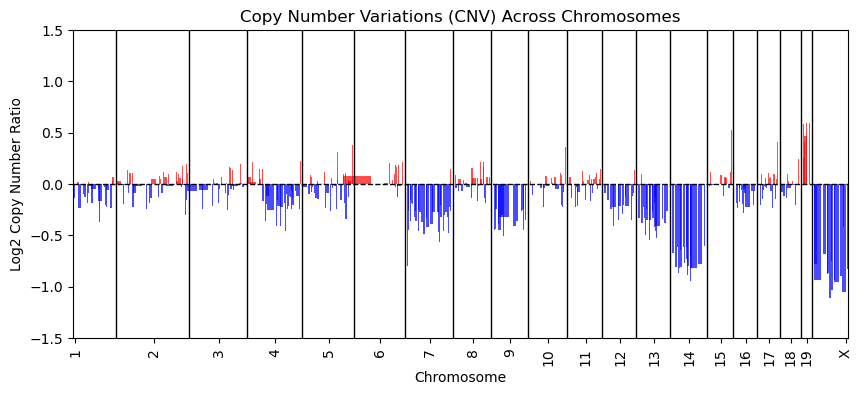

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load CNS file
file_path = "/bgfs/alee/LO_LAB/Personal/Daisong/CPT6/CNVkit/CPT6.cns"
cns_data = pd.read_csv(file_path, sep="\t")

# Convert chromosome names (remove 'chr' prefix if needed)
cns_data['chromosome'] = cns_data['chromosome'].str.replace('chr', '')

# Convert chromosome numbers to proper sorting order
cns_data['chromosome'] = pd.Categorical(cns_data['chromosome'], 
                                        categories=[str(i) for i in range(1, 20)] + ['X'], 
                                        ordered=True)

# Sort by chromosome and start position
cns_data = cns_data.sort_values(by=['chromosome', 'start'])

# Determine chromosome lengths for proportional spacing
chrom_lengths = cns_data.groupby('chromosome')['end'].max()
max_length = chrom_lengths.max()
chrom_scale_factors = {chrom: length / max_length for chrom, length in chrom_lengths.items() if pd.notna(chrom)}

# Adjust figure size for better visualization
plt.figure(figsize=(10, 4))

# Squeeze chromosome size by scaling the genomic positions
scale_factor = 5e6  # Adjust this factor to control compression

# Plot CN segments per chromosome horizontally
x_offset = 0
chrom_positions = []
chrom_labels = []
  # Add vertical line before chr1
for chrom in [c for c in cns_data['chromosome'].unique() if c in chrom_scale_factors]: 
    chrom_data = cns_data[cns_data['chromosome'] == chrom]
    scaled_factor = chrom_scale_factors[chrom]  # Apply proportional scaling
    plt.bar((chrom_data['start'] / scale_factor) * scaled_factor + x_offset, chrom_data['log2'], 
            width=((chrom_data['end'] - chrom_data['start']) / scale_factor) * scaled_factor, 
            color=['red' if x > 0 else 'blue' for x in chrom_data['log2']], alpha=0.7)
    chrom_positions.append(x_offset + ((chrom_data['end'].max() + chrom_data['start'].min()) / (2 * scale_factor)) * scaled_factor)
    chrom_labels.append(chrom)
    x_offset += ((chrom_data['end'].max() - chrom_data['start'].min()) / scale_factor) * scaled_factor + 2  # Adjust spacing proportionally
    plt.axvline(x=x_offset - 1, color='black', linestyle='-', linewidth=1)  # Add vertical line
    
# Formatting
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Chromosome")
plt.ylabel("Log2 Copy Number Ratio")
plt.title("Copy Number Variations (CNV) Across Chromosomes")
plt.xticks(ticks=chrom_positions, labels=chrom_labels, rotation=90)
plt.ylim(-1.5, 1.5)
plt.xlim(min(chrom_positions) - 1, max(chrom_positions) + 1)
plt.show()